###  Computing spectral analysis on the data to estimate pairwise coherence

The methods to compute the spectral analysis can be imported as follows:

In [20]:
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')

import time
import h5py
import scipy
import numpy                 as     np
import xarray                as     xr
import matplotlib.pyplot     as     plt
from   GDa.spectral_analysis import filtering, time_frequency
from   GDa.session           import session

# Auxiliary function to smooth
def smooth(x, w):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')

Loading a session using the session class:

In [2]:
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,\
              slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])
ses.read_from_mat()

We can plot a random LFP signal:

In [3]:
lfp   = ses.data[0,10,:]
# Time axis, using from -0.65 to 3.00 s because this is the event dt we used when we saved the data
tarr  = ses.time

Text(0, 0.5, 'mV')

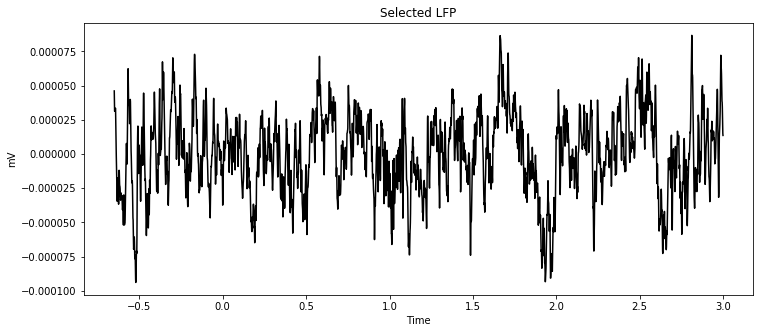

In [4]:
# Plotting the signal
plt.figure(figsize=(12,5))
plt.plot(tarr, lfp, 'k')
plt.title('Selected LFP')
plt.xlabel('Time')
plt.ylabel('mV')

We can bandpass filter the data with the function __bp_filter__ from __filtering__, let's filter it on the alpha band (8-15 Hz):

In [5]:
LFP_filtered = filtering.bp_filter(data = ses.data, fs = ses.data.attrs['fsample'], 
                                   f_low = 8, f_high = 12, n_jobs = -1)

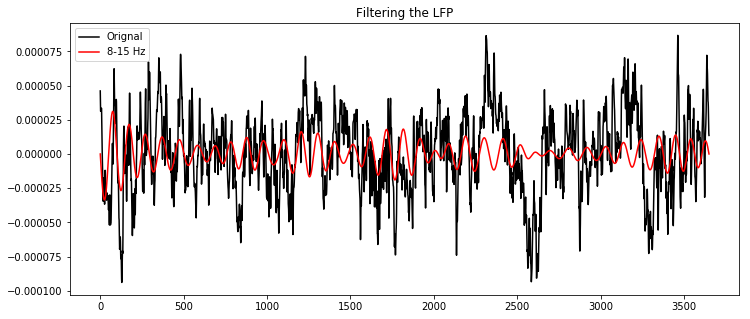

In [6]:
plt.figure(figsize=(12,5))
plt.plot(lfp, 'k')
plt.plot(LFP_filtered[0,10,:], 'r')
plt.title('Filtering the LFP')
plt.legend(['Orignal', '8-15 Hz'])

We can compute the wavelets of the signal using the function __wavelet_transform__, which allows to use morlet or multitaper transforms.

In [7]:
# Bands for each monkey
bands = {
        'lucy':  [[0.1,6],[6,14],[14,26],[26,42],[42,80]],
        'ethyl': [[0.1,8],[8,21],[21,33],[33,80]]
        }
# Range of frequencies to be analyzed
freqs = np.linspace(0.1, 80, 50) 

# Morlet
W_ml = time_frequency.wavelet_transform(data = ses.data,  
                                        fs = ses.data.attrs['fsample'], freqs = freqs, n_cycles = freqs/2,
                                        time_bandwidth = None, delta = 15, method = 'morlet', n_jobs = -1)

# Multitaper
#W_mt = spec.wavelet_transform(data = LFP,  
#                              fs = fsample, freqs = freqs, n_cycles = freqs/2.0,
#                              time_bandwidth = 8.0, delta = 15, method = 'multitaper', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   30.1s remaining:   43.7s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   32.9s remaining:   20.9s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   35.7s remaining:    8.0s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   40.1s finished


The auto spectra can be computed as tem elementwise product of $W$ and its conjugate:

In [8]:
Sauto_ml = W_ml * np.conj(W_ml)

Next, we can visualize the result for __trial=0__, and __channel=10__:

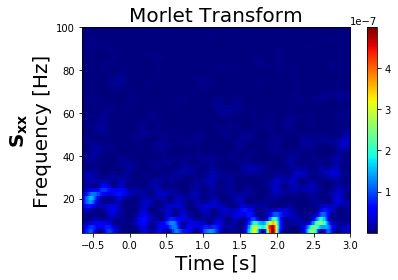

In [9]:
plt.imshow(Sauto_ml[0,10,:,:].real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,4,100])
plt.colorbar()
plt.title('Morlet Transform', fontsize=20)
plt.ylabel(r"$\bf{S_{xx}}$" + "\n" + "Frequency [Hz]", fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.tight_layout()

Finally we can compute the (single trial) time-frequency coherence between two signals by using the function __wavelet_coherence__, for each trial and pair a file will be saved in __dir_out__ with the coherence data.

An array with the pairs of channels (pairs = $[[0,1], [0,2], \dots, [n,n]]$) should be passed to the function (note that you don't necessarily have to provide every pair possible, you can also focus on a few pairs you are interested).

If $n_{\rm jobs}>1$, it will parallelize on pairs of channels, to test let's compute it passing only one trial of the data, and measure the execution time:

In [17]:
start = time.time()

time_frequency.wavelet_coherence(data = ses.data[:10,:,:], pairs = ses.data.attrs['pairs'], 
                                 fs = ses.data.attrs['fsample'], freqs = freqs, n_cycles = freqs/2, 
                                 time_bandwidth = None, delta = 15, method = 'morlet', 
                                 win_time = 34, win_freq = 1, dir_out = 'data', n_jobs = -1)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    0.7s finished


Elapsed time to load super-tensor: 10.518179416656494 sec.


We can load a saved file with the coherence in order to plot:

In [18]:
import h5py
with h5py.File('data/ch1_10_ch2_30.h5', 'r') as hf:
    coh = np.array(hf.get('coherence'))

Text(0.5, 0, 'Time [s]')

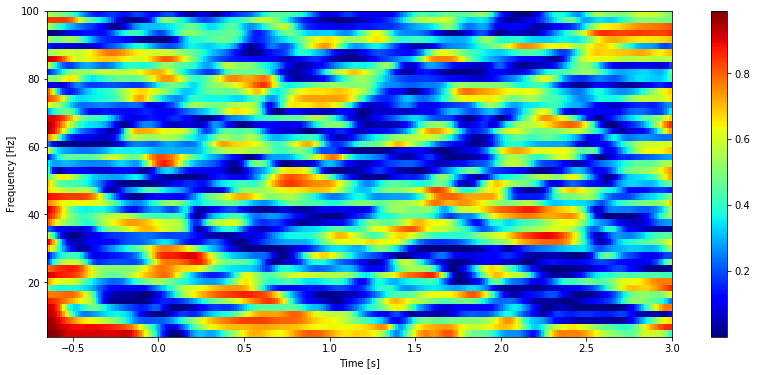

In [22]:
plt.figure(figsize=(14,6))
plt.imshow(coh[0,:,:], aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65,3,4,100]); plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

### SUPERLETS

In [27]:
try:
    import cupy as cp
    from cusignal.convolution.convolve import fftconvolve
except:
    cp = np
    from scipy.signal import fftconvolve
    np.asnumpy = np.asarray


def bw_cf(t, bw, cf):
    """Computes the complex wavelet coefficients for the desired time point t,
    bandwidth bw and center frequency cf"""
    cnorm = 1 / (bw * np.sqrt(2 * np.pi))
    exp1 = cnorm * np.exp(-(t ** 2) / (2 * (bw ** 2)));
    res = np.exp(2j * np.pi * cf * t) * exp1
    return res


def gauss(t, sd):
    """Compute the gaussian coefficient for the desired time point t and
    standard deviation sd"""
    cnorm = 1 / (sd * np.sqrt(2 * np.pi))
    res = cnorm * np.exp(-(t ** 2) / (2 * (sd ** 2)))
    return res


def cxmorlet(fc, n_cycles, sfreq):
    """Computes the complex Morlet wavelet for the desired center frequency.
    
    Parameters
    ----------
    fc : center frequency
    n_cycles : number of cycles
    sfreq : sampling frequency
    """
    # we want to have the last peak at 2.5 SD
    sd = (n_cycles / 2) * (1 / fc) / 2.5
    wl = int(2 * np.floor(np.fix(6 * sd * sfreq) / 2) + 1)
    w = np.zeros((wl), dtype=np.complex128)
    gi = 0
    off = np.fix(wl / 2)
    for i in range(wl):
        t = (i - off) / sfreq
        w[i] = bw_cf(t, sd, fc)
        gi += gauss(t, sd)
    w /= gi
    return w


def aslt(data, sfreq, foi, n_cycles, order=None, mult=False):
    """Adaptive superresolution wavelet (superlet) transform.
    
    - data (array_like) : (n_epochs, n_times)
    - sfreq (float) : sampling frequency
    - foi (array_like) : central frequency of interest
    - n_cycles (integer) : number of initial wavelet cycles
    - order (array_like) : interval of super-resolution orders of shape (2,).
      For example, use order=[1, 30]
    - mult (bool) : specifies the use of multiplicative super-resolution (True)
      or additive (False)
    """
    # inputs checking
    assert isinstance(data, np.ndarray)
    data = np.atleast_2d(data).astype(np.float32)
    n_epochs, n_times = data.shape
    foi = np.asarray(foi)
    n_freqs = len(foi)

    # check order parameter and initialize the order used at each frequency. If
    # empty, go with an order of 1 for each frequency (single wavelet per set)
    if order is not None:
        order_ls = np.fix(np.linspace(order[0], order[1], n_freqs)).astype(int)
    else:
        order_ls = np.ones((n_freqs,), dtype=np.int)
        
    # the padding will be size of the lateral zero-pads, which serve to avoid
    # border effects during convolution
    padding = 0
    
    # the wavelet sets
    wavelets = dict()
    
    # initialize wavelet sets for either additive or multiplicative
    # superresolution
    for i_freq in range(n_freqs):
        for i_ord in range(order_ls[i_freq]):
            # get the number of cycles
            if mult:  # multiplicative superresolution
                n_cyc = n_cycles * (i_ord + 1)
            else:     # additive superresolution
                n_cyc = n_cycles + i_ord
            
            # each new wavelet has n_cyc extra cycles
            _w = cxmorlet(foi[i_freq], n_cyc, sfreq)
            
            # the margin will be the half-size of the largest wavelet
            padding = max(padding, np.fix(len(_w) / 2))
            
            wavelets[(i_freq, i_ord)] = _w
    
    # the zero-padded buffer
    buffer = cp.zeros((n_epochs, int(n_times + 2 * padding)),
                      dtype=cp.float32)

    # convenience indexers for the zero-padded buffer
    bufbegin = int(padding)
    bufend = int(padding + n_times)
    
    # fill the central part of the buffer with input data
    buffer[:, bufbegin:bufend] = cp.asarray(data)
    
    # the output scalogram
    wtresult = cp.zeros((n_epochs, n_freqs, n_times), dtype=cp.float32)

    for i_freq in range(n_freqs):
        # pooling buffer, starts with 1 because we're doing geometric mean
        temp = cp.ones((n_epochs, n_times), dtype=cp.float32)

        # compute the convolution of the buffer with each wavelet in the
        # current set
        for i_ord in range(order_ls[i_freq]):
            # get the single wavelets
            sw = cp.asarray(wavelets[(i_freq, i_ord)]).reshape(1, -1)
    
            # restricted convolution (input size == output size)
            _temp = fftconvolve(buffer, sw, mode='same', axes=1)

            # accumulate the magnitude (times 2 to get the full spectral
            # energy
            temp *= (2 * cp.abs(_temp[:, bufbegin:bufend]))

        # compute the power of the geometric mean
        root = 1. / float(order_ls[i_freq])
        temp = (temp ** root) ** 2

        # accumulate the current FOI to the result spectrum
        wtresult[:, i_freq, :] += temp
    
    return cp.asnumpy(wtresult)

In [31]:
b_names = [r'$\theta$', r'$\alpha$', r'$\beta$', r'low-$\gamma$', r'high-$\gamma$']

In [33]:
foi = np.arange(2, 150, 2)

n_cycles = 3
sfreq = 1000.

tf = aslt(ses.data[:,0,:].values, sfreq, foi, n_cycles, order=[1, 8], mult=True)

In [34]:
W_aslt = tf.mean(axis = 0)

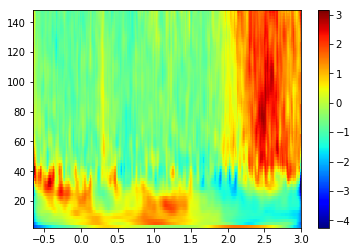

In [35]:
aux = tf[:,:,::15].mean(axis=0)
aux = (aux-aux.mean(axis=1)[:,None])/aux.std(axis=1)[:,None]
plt.imshow(aux, aspect='auto', cmap='jet', origin='lower', 
           extent = [ses.time[0],ses.time[-1],foi[0],foi[-1]])
plt.colorbar()

In [43]:
W_ml = time_frequency.wavelet_transform(data = ses.data[:,0,:].values[:,None,:],  
                                        fs = ses.data.attrs['fsample'], freqs = foi, n_cycles = foi/2,
                                        time_bandwidth = None, delta = 15, method = 'morlet', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:   16.2s finished


In [44]:
W_dwt = np.squeeze( (W_ml * np.conj(W_ml)).real)

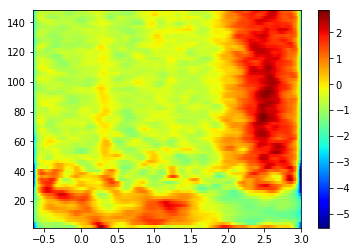

In [45]:
aux = W_dwt.mean(axis=0)
aux = (aux-aux.mean(axis=1)[:,None])/aux.std(axis=1)[:,None]
plt.imshow(aux, aspect='auto', cmap='jet', origin='lower', 
           extent = [ses.time[0],ses.time[-1],foi[0],foi[-1]])
plt.colorbar()

### Multitaper estimation of coherence

To estimate the coherence (or spectra) in given bands we can use the multitaper method. Supose that we have the center frequencies of each band $f_c = \{f_{0},\dots, f_{n}\}$, where $n$ is the number of bands, and the bandwidth of each band $\delta f = \{\delta f_{0},\dots,\delta f_{n}\}$.

If $t_b$ is the time bandwidth of the Multitaper transform, the number of cycles can be computed by:

$n_\rm{cycles} = t_b\frac{f_c}{\delta f}$

This can be used to compute the spctra (and the coherence) directly in each band of interest.

In [10]:
# Method to compute number of cycles for each band and bandwidth
def compute_n_cycles(f_c, d_f, time_bandwidth):
    return time_bandwidth * f_c / d_f

In [11]:
# Frequency centers
f_c = np.mean( bands['lucy'], axis = 1)
# Bandwidth
d_f = np.ceil( (np.array(bands['lucy'])[:,1]-np.array(bands['lucy'])[:,0])/2 )
# Time-bandwidth
time_bandwidth = 8.0
# Number of cycles
n_cycles = compute_n_cycles(f_c,d_f,time_bandwidth)

#### Power

In [12]:
freqs = np.arange(4, 100, 2)

W_ml = time_frequency.wavelet_transform(data = ses.data,  
                                        fs = ses.data.attrs['fsample'], freqs = f_c, n_cycles = n_cycles,
                                        time_bandwidth = time_bandwidth, delta = 15, method = 'multitaper', 
                                        n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:   19.6s remaining:   28.4s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:   20.3s remaining:   12.8s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:   20.9s remaining:    4.7s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:   29.3s finished


In [13]:
W_ml = xr.DataArray( W_ml, dims = ('trials', 'roi', 'bands', 'time') )

In [14]:
P = W_ml * np.conj(W_ml)

In [15]:
# Baseline correcting
P = (P - P.mean(dim='time')) / P.std(dim='time')

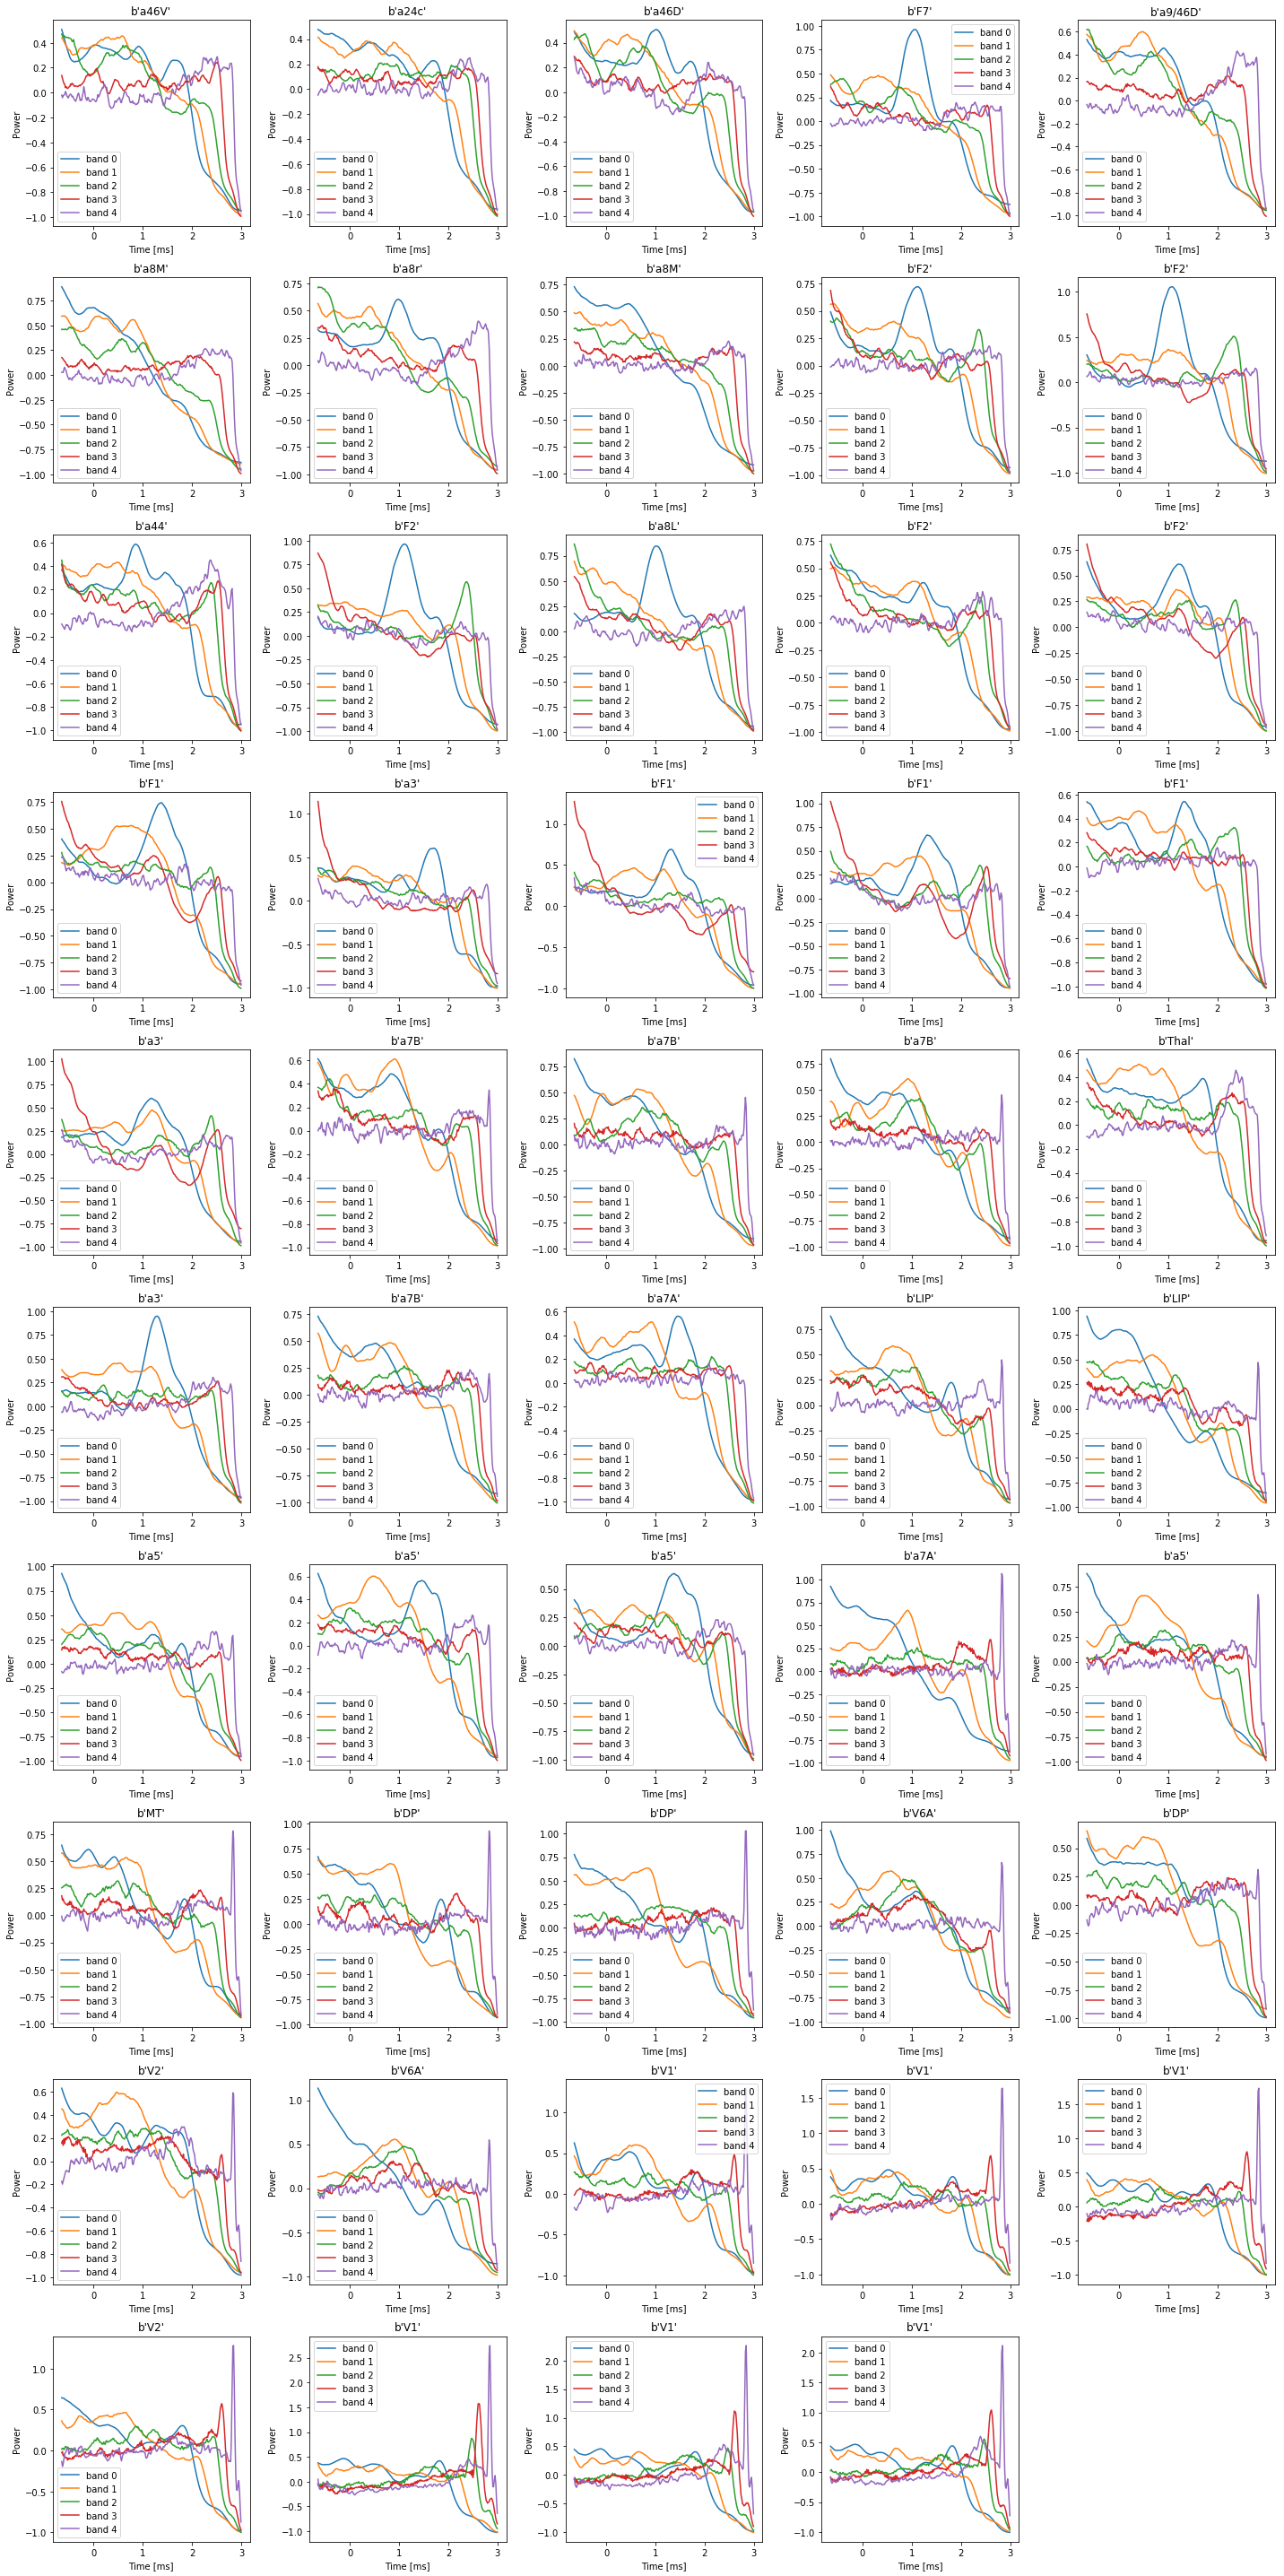

In [16]:
plt.figure(figsize=(20,40))
count = 1
for i in range(ses.data.attrs['nC']):
    plt.subplot(10,5,count)
    for j in range(len(bands['lucy'])):
        plt.plot(ses.data.time[::15], P.mean(dim = 'trials').real[i,j], label = 'band ' + str(j))
        plt.ylabel('Power')
        plt.xlabel('Time [ms]')
        plt.title(ses.data.attrs['areas'][i])
    count = count + 1
    plt.legend()
plt.tight_layout()
plt.savefig('power_mt.pdf', dpi = 600)

#### Coherence

In [39]:
time_frequency.wavelet_coherence(data = ses.data[:100,:,:], pairs = ses.data.attrs['pairs'], 
                                 fs = ses.data.attrs['fsample'], freqs = f_c, n_cycles = n_cycles, 
                                 time_bandwidth = time_bandwidth, delta = 15, method = 'multitaper', 
                                 win_time = 35, win_freq = 1, dir_out = 'data', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  20 out of  49 | elapsed:    6.0s remaining:    8.7s
[Parallel(n_jobs=40)]: Done  30 out of  49 | elapsed:    6.2s remaining:    3.9s
[Parallel(n_jobs=40)]: Done  40 out of  49 | elapsed:    6.3s remaining:    1.4s
[Parallel(n_jobs=40)]: Done  49 out of  49 | elapsed:    7.4s finished


In [40]:
with h5py.File('data/ch1_10_ch2_30.h5', 'r') as hf:
    coh = np.array(hf.get('coherence'))

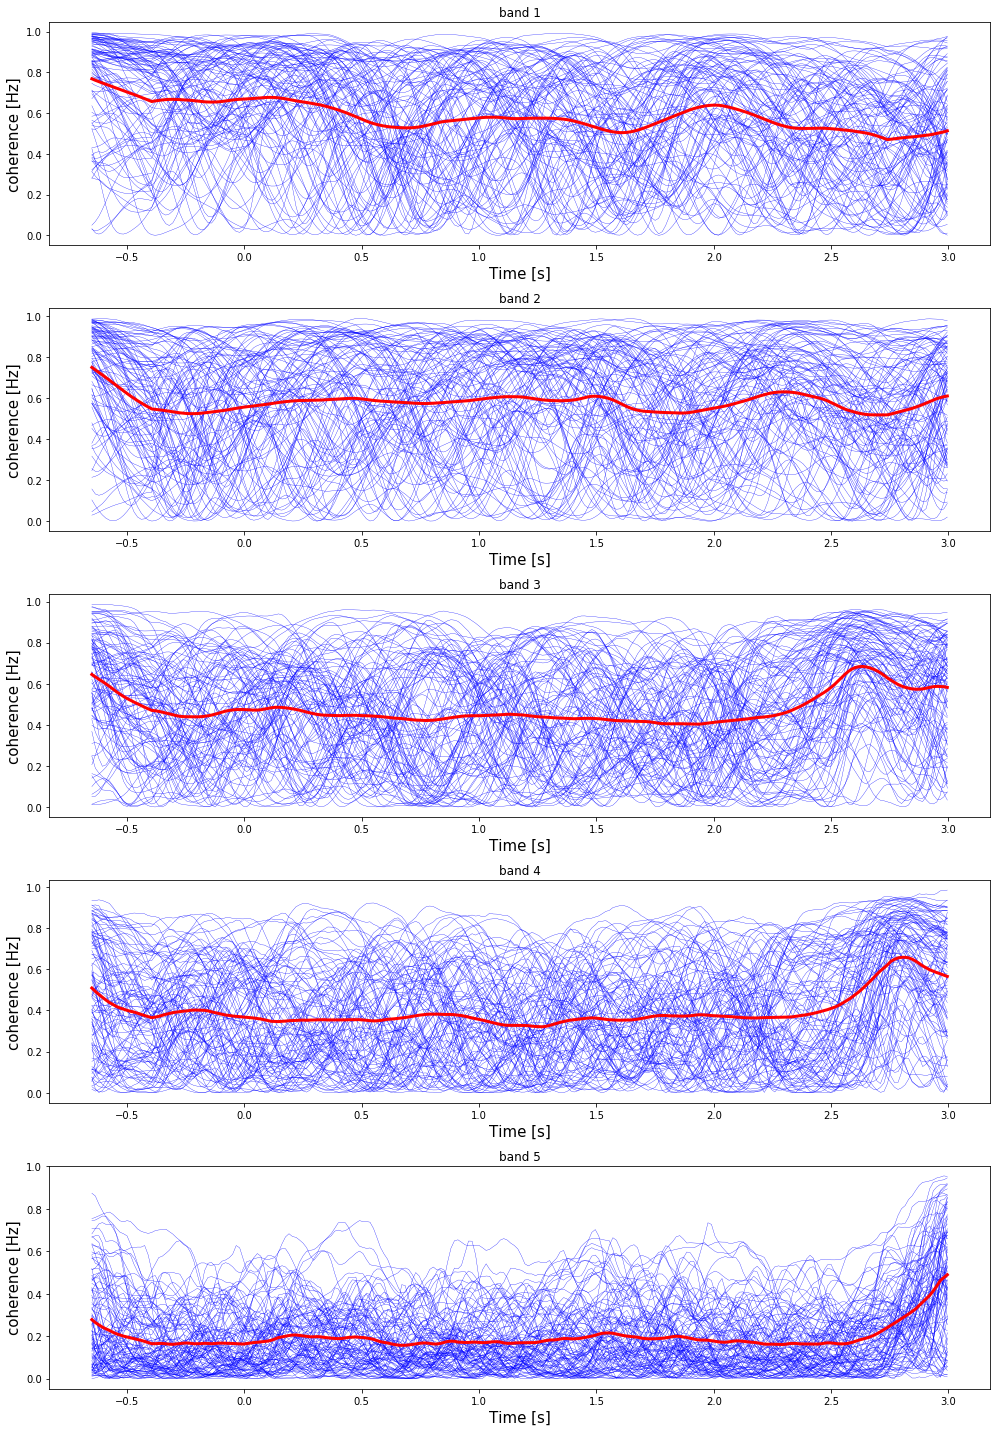

In [45]:
plt.figure(figsize=(14,20))
count = 1
for i in range(len(bands['lucy'])):
    plt.subplot(len(bands['lucy']),1,count)
    for j in range(100):
        plt.plot(ses.data.time[::15], coh[j,i,:], color='b', lw=.3)
        plt.title('band ' + str(i+1))
        plt.ylabel('coherence [Hz]', fontsize=15)
        plt.xlabel('Time [s]', fontsize=15)
    plt.plot(ses.data.time[::15], coh[:,i,:].mean(axis=0), color='r', lw=3)
    count += 1
plt.tight_layout()
plt.savefig('coherence_mt.pdf', dpi = 600)